In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tqdm

import os, sys, torch, dgl
import numpy as np
import pandas as pd
from torch_geometric.data import Data

from turtle import forward
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import dgl
import dgl.nn.pytorch as dglnn
# from dgl.nn import Set2Set

from torch_geometric.nn import SAGEConv, SAGPooling, Set2Set, GraphNorm, global_sort_pool, GlobalAttention
from torch_geometric.utils import add_self_loops, subgraph
# from torch_geometric.loader import DataLoader

from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics

import dgl
from dgl.nn.pytorch.factory import KNNGraph
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GATConv

# read dataset

In [2]:
# omics_files= ["./data/GBM/GBM.expression.csv.gz", "./data/GBM/GBM.met.csv.gz", "./data/GBM/GBM.cnv.csv.gz"]
# label_file = "./data/GBM/labels.csv"

In [75]:
omics_files=["/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/rna.csv.gz", 
             "/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/cnv.csv.gz",
             "/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/met.csv.gz",
            ]
label_file = "./dataset/GBM/labels.csv"
clin_files = "/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/clin.csv.gz"

In [76]:
# 读取组学数据集
df_omics = []
for f in omics_files:
    df_omics.append( pd.read_csv(f, index_col=0, compression='gzip') )

In [77]:
df_omics[0]

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
TCGA.02.0001,6.5006,8.7297,5.5114,4.8830,10.9848,7.5352,8.6740,5.0326,4.7110,5.1085,...,7.0312,7.1536,9.0489,4.3661,6.0540,12.9119,11.8723,6.8677,10.3541,4.7099
TCGA.02.0003,6.5392,9.7944,6.2140,4.8363,10.8112,6.9979,9.3486,5.0270,5.3277,4.3486,...,6.3055,4.0069,8.8645,4.3853,6.6742,13.4194,11.1097,8.1478,11.3674,4.1964
TCGA.02.0004,7.3778,12.0596,7.0517,6.1124,10.4364,9.1321,11.2485,5.5591,8.2682,4.0524,...,5.9481,4.0251,8.8457,4.8149,6.4645,13.2296,11.3210,8.5192,10.3795,3.7339
TCGA.02.0007,7.1869,4.9451,5.2304,5.8186,10.4773,8.3561,4.4295,5.1759,4.4405,4.8242,...,6.5024,4.2905,8.4836,4.7985,5.0602,13.5751,11.6656,9.1899,11.4782,4.3231
TCGA.02.0009,7.6750,10.8401,6.6207,5.3332,10.6373,6.9429,9.4522,5.1649,4.9522,4.2046,...,5.1425,5.4105,9.2392,4.3432,6.4780,13.2870,11.4804,8.5564,10.4047,4.6391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.76.6193,6.9078,11.0918,7.8877,4.6878,10.4751,9.1383,8.8234,5.8607,7.6563,4.0581,...,7.5395,3.9214,9.5287,5.3819,6.7406,13.3434,10.1613,9.2649,10.7787,3.6473
TCGA.76.6282,7.0076,10.7895,7.5698,5.3670,10.5730,9.4382,9.3430,5.5792,8.8727,4.2519,...,7.0506,3.8547,9.6149,6.4983,6.6245,13.1790,10.8780,8.8396,9.9779,3.7119
TCGA.76.6285,7.6763,9.6826,7.0198,4.6857,10.4392,10.2042,8.1278,5.4004,8.4735,4.1489,...,6.8089,3.8723,9.4569,7.9970,6.7170,13.5058,10.5722,8.8872,9.4662,3.6692
TCGA.81.5910,7.1052,9.8474,7.5335,6.1549,10.6853,10.2206,7.0747,6.1500,8.5697,4.3660,...,7.6320,3.9390,9.5651,5.7329,5.3812,13.3282,11.1809,9.8162,8.0059,3.8327


In [66]:
# 读取临床特征
df_clin = pd.read_csv(clin_files, compression='gzip', index_col=0)

In [67]:
df_clin

,years_to_birth,Tumor_purity,histological_type_glioblastomamultiforme(gbm),histological_type_treatedprimarygbm,histological_type_untreatedprimary(denovo)gbm,gender_female,gender_male,radiation_therapy_no,radiation_therapy_yes
attrib_name,,,,,,,,,
TCGA.06.6391,0.44,0.8360,0,0,1,1,0,1,0
TCGA.19.A6J4,0.68,0.6736,1,0,0,0,1,0,0
TCGA.06.1806,0.47,0.7913,1,0,0,0,1,0,1
TCGA.06.5408,0.54,0.8635,0,0,1,1,0,0,1
TCGA.06.5410,0.72,0.3396,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...
TCGA.76.6283,0.71,0.9779,1,0,0,1,0,0,0
TCGA.76.6660,0.73,0.7707,1,0,0,0,1,0,0
TCGA.81.5910,0.64,0.7913,0,0,1,0,1,1,0


In [73]:
# 读取标签
df_label = pd.read_csv(label_file, index_col=0)

df_label

,label
patient_id,
TCGA.06.6391,1
TCGA.19.A6J4,1
TCGA.06.1806,1
TCGA.06.5408,1
TCGA.06.5410,1
...,...
TCGA.76.6280,1
TCGA.76.6283,1
TCGA.76.6660,1


In [74]:
df_label = df_label.rename(
        columns={df_label.columns.values[0]: 'patient'})
df_label

,patient
patient_id,
TCGA.06.6391,1
TCGA.19.A6J4,1
TCGA.06.1806,1
TCGA.06.5408,1
TCGA.06.5410,1
...,...
TCGA.76.6280,1
TCGA.76.6283,1
TCGA.76.6660,1


In [7]:
# 计算患者交集
patients = [df_tmp.index.to_list() for df_tmp in df_omics]
patients.append(df_clin.index.to_list())
patients.append(df_label.index.to_list())

patients_shared = patients[0]
print(len(patients_shared))
for i in range(1, len(patients)):
    patients_shared = list(set(patients_shared).intersection(patients[i]))
    print(len(patients[i]), len(patients_shared))

len(patients_shared)

528
577 508
285 270
567 254
494 220


220

In [8]:
# 提取交集
for i in range(len(df_omics)):
    df_omics[i] = df_omics[i].loc[patients_shared, :]
df_clin = df_clin.loc[patients_shared, :]
df_label = df_label.loc[patients_shared, :]

In [9]:
def check_v1(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    _, X_test, _, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    label_1 = [True if i==1 else False for i in y_test]
    label_0 = [True if i==0 else False for i in y_test]
    pvalue_02 = stats.kstest(X_test[label_1], X_test[label_0]).pvalue
    pvalue_03 = stats.kstest(X_test, data).pvalue
       
    return pvalue_01, pvalue_02, pvalue_03

In [34]:
dat = df_omics[0].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)


df_boot = pd.DataFrame()

for i in tqdm.tqdm(range(dat.shape[1])):
    data = dat[:, i]
    m = 0
    for n, seed in enumerate(seeds):
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            m += 1
    m = m / n
    df_boot.loc[i, 'rna'] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████| 12042/12042 [05:31<00:00, 36.35it/s]


In [35]:
dat = df_omics[1].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)


# df_boot = pd.DataFrame(columns=list(range(df_omics[0].shape[1])))

for i in tqdm.tqdm(range(dat.shape[1])):
    data = dat[:, i]
    m = 0
    for n, seed in enumerate(seeds):
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            m += 1
    m = m / n
    df_boot.loc[i, 'cnv'] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████| 24776/24776 [11:09<00:00, 36.99it/s]


In [36]:
dat = df_omics[2].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)


# df_boot = pd.DataFrame(columns=list(range(df_omics[0].shape[1])))

for i in tqdm.tqdm(range(dat.shape[1])):
    data = dat[:, i]
    m = 0
    for n, seed in enumerate(seeds):
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            m += 1
    m = m / n
    df_boot.loc[i, 'met'] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████| 13774/13774 [06:24<00:00, 35.79it/s]


In [48]:
p = 0.7
rna = df_boot[df_boot.rna > p].index.to_list()
cnv = df_boot[df_boot.cnv > p].index.to_list()
met = df_boot[df_boot.met > p].index.to_list()

In [49]:
len(rna), len(cnv), len(met)

(43, 3, 33)

In [10]:
dat = df_omics[1].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))

cnv = candidates_list

100%|███████████████████████████████████████████████████████████████████████████████████████████| 24776/24776 [01:08<00:00, 363.45it/s]


Seed: 102 | Candidates' Number: 444


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:01<00:00, 368.77it/s]


Seed: 435 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 348.41it/s]


Seed: 860 | Candidates' Number: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 314.78it/s]


Seed: 270 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 106 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 121 | Candidates' Number: 0


In [11]:
dat = df_omics[2].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))

met = candidates_list

100%|███████████████████████████████████████████████████████████████████████████████████████████| 13774/13774 [00:38<00:00, 358.35it/s]


Seed: 102 | Candidates' Number: 328


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:00<00:00, 372.23it/s]


Seed: 435 | Candidates' Number: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 362.74it/s]


Seed: 860 | Candidates' Number: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 359.38it/s]


Seed: 270 | Candidates' Number: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 347.64it/s]


Seed: 106 | Candidates' Number: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.62it/s]


Seed: 71 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 349.79it/s]


Seed: 700 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 310.86it/s]


Seed: 20 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 338.95it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 121 | Candidates' Number: 0


In [3]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
dat = df.values

In [13]:
df = pd.read_csv(omics_files[0], compression='gzip')
df

,gene,TCGA.12.3652,TCGA.19.0960,TCGA.12.1099,TCGA.06.0130,TCGA.02.0028,TCGA.28.1750,TCGA.32.2616,TCGA.06.2564,TCGA.16.1056,...,TCGA.12.1091,TCGA.06.2570,TCGA.32.1986,TCGA.19.2629,TCGA.14.1795,TCGA.27.2524,TCGA.02.0074,TCGA.02.0057,TCGA.06.0876,TCGA.28.1747
0,65985,7.1738,7.3166,6.8582,6.5383,6.2721,7.0676,8.0759,7.2686,5.9117,...,6.7674,7.1291,7.0174,7.1295,6.8996,7.6271,7.1464,7.1611,7.0298,7.1537
1,11167,9.3542,8.4556,8.0170,11.1657,9.0426,10.0037,10.1780,10.5338,10.3707,...,8.9370,9.4463,10.8694,9.5244,9.2726,9.8123,9.7812,10.2272,9.9774,10.3286
2,63916,6.6920,7.4992,6.5713,6.7394,5.9621,7.0352,7.3856,7.8099,6.2439,...,6.7410,7.7636,7.0640,7.9254,6.8660,6.8903,7.6113,6.4961,7.0368,8.1422
3,6205,11.6890,10.6997,10.7380,10.5810,10.5937,10.4388,11.1990,10.7997,10.7321,...,11.0581,10.8540,10.5805,10.9335,10.2738,11.0040,10.6266,10.5731,11.6288,10.5701
4,9240,9.7894,10.1381,9.0477,8.2948,7.2465,9.1440,9.8858,10.2969,9.5922,...,8.8233,10.3760,10.1381,9.8334,10.1661,9.6827,9.3484,8.9108,9.5088,10.3280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8569,6232,13.4681,13.3225,13.2468,12.9222,13.2518,12.5522,13.3687,13.2221,13.2427,...,13.4064,13.4744,13.3066,13.2431,12.5956,13.2832,12.7542,13.3787,13.4558,13.0392
8570,6633,12.5007,9.5415,10.7869,11.1401,10.6949,10.8122,10.6902,10.7629,10.0993,...,10.9102,10.9260,10.9236,10.6743,11.0020,12.3243,11.5169,11.1037,11.3967,11.0119
8571,25800,9.0119,9.7287,9.2825,9.4069,7.3751,8.7975,8.8737,9.2659,9.0218,...,9.5355,9.7649,9.3658,10.3708,9.1447,8.9571,10.5572,8.4873,8.7153,9.1383
8572,1075,7.6762,9.1204,9.0587,10.7588,11.3272,9.9070,8.9027,9.2750,8.7297,...,8.5790,9.2406,9.4352,9.4494,9.5590,11.1655,9.4927,10.9043,9.0236,9.3242


In [4]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
df

gene,65985,11167,63916,6205,9240,4313,23034,6604,51146,23051,...,66035,4318,2822,4218,113791,6232,6633,25800,1075,364
TCGA.02.0001,6.5006,8.7297,5.5114,10.9848,7.5352,8.6740,5.0326,4.7110,5.1085,5.0578,...,3.8104,10.1073,4.2646,9.0489,6.0540,12.9119,11.8723,6.8677,10.3541,4.7099
TCGA.02.0003,6.5392,9.7944,6.2140,10.8112,6.9979,9.3486,5.0270,5.3277,4.3486,5.0185,...,3.8114,9.2451,4.3928,8.8645,6.6742,13.4194,11.1097,8.1478,11.3674,4.1964
TCGA.02.0007,7.1869,4.9451,5.2304,10.4773,8.3561,4.4295,5.1759,4.4405,4.8242,5.3092,...,4.0554,4.9841,4.3993,8.4836,5.0602,13.5751,11.6656,9.1899,11.4782,4.3231
TCGA.02.0009,7.6750,10.8401,6.6207,10.6373,6.9429,9.4522,5.1649,4.9522,4.2046,5.1934,...,3.7961,9.4838,4.1058,9.2392,6.4780,13.2870,11.4804,8.5564,10.4047,4.6391
TCGA.02.0010,7.9960,8.9316,7.5524,11.0015,8.0444,4.5017,4.9701,8.6390,4.7297,5.6876,...,4.3457,6.3779,4.4098,9.3678,5.7048,13.4803,10.9516,9.2099,8.4179,4.1673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2573,8.3524,9.2781,8.2224,10.9342,10.4176,7.7750,5.1610,9.2291,4.2301,6.7163,...,4.2878,7.4442,4.4620,8.7003,7.2960,13.1763,11.1698,10.1071,9.2850,3.6602
TCGA.41.2575,7.4707,9.0223,7.2680,11.1522,9.0870,8.1914,5.3809,9.4080,4.3760,6.8908,...,4.2864,5.6763,4.6100,8.5116,6.0337,13.4874,11.4938,9.9421,8.5357,3.8522
TCGA.41.3392,7.7575,10.1369,7.7922,11.2145,10.4248,7.9187,5.6151,10.1912,4.1216,7.0976,...,4.2259,7.6174,4.2795,8.7327,7.0284,13.2740,11.7869,9.0605,8.7931,3.6826
TCGA.41.3393,7.1475,9.7595,7.7017,10.9388,9.6555,8.5737,6.0901,8.5130,4.1553,6.8399,...,4.2960,7.9491,4.3866,9.2732,5.9184,13.0283,11.2973,9.6774,10.2152,3.8290


In [20]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
patients = labels.patient_id.values
labels = labels.label.values
len(patients)

448

# KS Test

In [10]:
def check(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    pvalue_tt = stats.kstest(X_train, X_test).pvalue
    
    # check label0 vs. label1 in training dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_train]
    label_0 = [True if i==0 else False for i in y_train]
    pvalue_01_train = stats.kstest(X_train[label_1], X_train[label_0]).pvalue
    
    # check label0 vs. label1 in testing dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_test]
    label_0 = [True if i==0 else False for i in y_test]
    pvalue_01_test = stats.kstest(X_test[label_1], X_test[label_0]).pvalue
    
    # label1: train vs. test: p>0.05
    label_1_test = [True if i==1 else False for i in y_test]
    label_1_train = [True if i==1 else False for i in y_train]
    pvalue_1_tt = stats.kstest(X_test[label_1_test], X_train[label_1_train]).pvalue
    
    # label0: train vs. test: p>0.05
    label_0_test = [True if i==0 else False for i in y_test]
    label_0_train = [True if i==0 else False for i in y_train]
    pvalue_0_tt = stats.kstest(X_test[label_0_test], X_train[label_0_train]).pvalue
    
    
    return pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt


In [76]:
def check_v1(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    pvalue_tt = stats.kstest(X_train, X_test).pvalue
    
    # check label0 vs. label1 in training dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_train]
    label_0 = [True if i==0 else False for i in y_train]
    pvalue_01_train = stats.kstest(X_train[label_1], X_train[label_0]).pvalue
    
    # check label0 vs. label1 in testing dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_test]
    label_0 = [True if i==0 else False for i in y_test]
    pvalue_01_test = stats.kstest(X_test[label_1], X_test[label_0]).pvalue
    
    # label1: train vs. test: p>0.05
    label_1_test = [True if i==1 else False for i in y_test]
    label_1_train = [True if i==1 else False for i in y_train]
    pvalue_1_tt = stats.kstest(X_test[label_1_test], X_train[label_1_train]).pvalue
    
    # label0: train vs. test: p>0.05
    label_0_test = [True if i==0 else False for i in y_test]
    label_0_train = [True if i==0 else False for i in y_train]
    pvalue_0_tt = stats.kstest(X_test[label_0_test], X_train[label_0_train]).pvalue
    
    
    return pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt

In [77]:
def distribution(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    _, X_test, _, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    
    pvalue_tt = stats.kstest(data, X_test).pvalue
#     print(data)
#     print(pvalue_01, pvalue_tt)
    return pvalue_01, pvalue_tt

## RNA

In [9]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.rename(columns={df.columns.values[0] : 'gene'})
df = df.drop_duplicates('gene', keep='first')
df = df.sort_values('gene').reset_index(drop=True)
df = df.fillna(0)  # fill nan with 0
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values
dat.shape

(220, 8574)

In [10]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_rna = dat

In [11]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
labels = labels.label.values
labels

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_test<0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:37<00:00, 225.99it/s]


Seed: 102 | Candidates' Number: 250


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 227.23it/s]


Seed: 435 | Candidates' Number: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 223.77it/s]


Seed: 860 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 210.98it/s]


Seed: 270 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 208.63it/s]


Seed: 106 | Candidates' Number: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.85it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 121 | Candidates' Number: 0


In [13]:
candidates_rna = candidates_list

## Met

In [14]:
df = pd.read_csv(omics_files[1], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_met = dat

In [15]:
df

gene,487,4223,3232,24145,3613,389,84525,7287,8148,60481,...,355,54829,50865,1429,9836,6144,10266,192286,6314,26073
TCGA.02.0001,0.3261,-0.4585,-0.0915,-0.3798,-0.4814,-0.4850,-0.2066,0.4394,-0.4758,-0.4719,...,-0.4846,0.3746,-0.4849,-0.4557,-0.4731,-0.4491,-0.4457,-0.4832,-0.4327,-0.4546
TCGA.02.0003,0.1966,-0.3961,-0.4494,-0.4289,-0.3722,-0.4794,-0.3266,0.4203,-0.4797,-0.4649,...,-0.4828,0.3752,-0.4854,-0.4613,-0.4576,-0.3708,-0.4599,-0.4677,-0.4462,-0.4537
TCGA.02.0007,0.3267,-0.4745,0.1464,-0.3042,-0.4815,-0.4652,-0.3636,0.4145,-0.4776,-0.4724,...,-0.4833,0.4064,-0.4818,-0.4710,-0.4772,-0.3221,-0.4614,-0.4745,-0.3596,-0.4561
TCGA.02.0009,0.3360,-0.4587,-0.3111,-0.3700,-0.4805,-0.4561,-0.4413,0.4328,-0.4760,-0.4705,...,-0.4790,0.4384,-0.4864,-0.4507,-0.4786,-0.4241,-0.4544,-0.4816,-0.4449,-0.4617
TCGA.02.0010,0.1871,-0.4627,-0.1366,-0.3640,-0.3567,-0.4867,-0.4539,0.4197,-0.4822,-0.4774,...,0.3486,0.4346,-0.4785,-0.4770,-0.4755,-0.4183,-0.4657,-0.4822,-0.4584,-0.4547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,0.0977,-0.4582,-0.0950,-0.4209,-0.4338,-0.4892,-0.3772,0.4169,-0.4692,-0.4775,...,-0.4888,0.4327,-0.4424,-0.4774,-0.4854,-0.4777,-0.4799,-0.4821,-0.4825,-0.4838
TCGA.41.2575,-0.4353,-0.4732,0.2135,-0.4350,-0.4839,-0.4841,-0.4442,0.3648,-0.4873,-0.4845,...,-0.4894,0.3271,-0.4847,-0.4837,-0.4812,-0.4675,-0.4773,-0.4833,-0.4758,-0.4739
TCGA.41.3392,-0.1843,-0.4676,-0.4177,-0.4255,-0.4835,-0.4870,-0.4216,0.3755,-0.4842,-0.4848,...,-0.4868,0.4094,-0.4829,-0.4807,-0.4761,-0.4427,-0.4711,-0.4761,-0.4771,-0.4572
TCGA.41.3393,0.2044,-0.4700,0.0912,-0.3737,-0.4840,-0.4869,-0.2230,0.4318,-0.4740,-0.4761,...,-0.4869,0.4376,-0.4575,-0.4837,-0.4854,-0.4780,-0.4736,-0.4855,-0.4717,-0.4809


In [16]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
labels = labels.label.values

labels

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 20)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_test<0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:37<00:00, 230.25it/s]


Seed: 102 | Candidates' Number: 235


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:01<00:00, 228.97it/s]


Seed: 435 | Candidates' Number: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 227.40it/s]


Seed: 860 | Candidates' Number: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 216.30it/s]


Seed: 270 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 211.12it/s]


Seed: 106 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 121 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 466 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 214 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 330 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 458 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 87 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 372 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 99 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 871 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 663 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 130 | Candidates' Number: 0


In [18]:
candidates_met = candidates_list

## CNV

In [19]:
df = pd.read_csv(omics_files[2], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_cnv = dat
df

gene,55210,54991,1855,2563,2782,9636,79906,55052,26155,55229,...,79174,5600,6300,23542,23209,29781,6305,9997,80305,9889
TCGA.02.0001,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,...,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008
TCGA.02.0003,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,...,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021
TCGA.02.0007,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,...,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988
TCGA.02.0009,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,...,0.039,0.039,0.039,0.039,0.039,0.039,0.039,0.039,0.039,0.039
TCGA.02.0010,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,...,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,...,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102
TCGA.41.2575,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,...,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075
TCGA.41.3392,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,...,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007
TCGA.41.3393,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,...,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034


In [20]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 20)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_test<0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:37<00:00, 230.86it/s]


Seed: 102 | Candidates' Number: 340


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 231.86it/s]


Seed: 435 | Candidates' Number: 168


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 229.22it/s]


Seed: 860 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 215.02it/s]


Seed: 270 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 212.39it/s]


Seed: 106 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 216.01it/s]


Seed: 71 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 211.37it/s]


Seed: 700 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 220.80it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 121 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 466 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 214 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 330 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 458 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 87 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 372 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 99 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 871 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 663 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 130 | Candidates' Number: 0


In [21]:
candidates_cnv = candidates_list

# 构建机器学习模型

In [43]:
data = np.concatenate([dat_rna[:, candidates_rna[1]], dat_met[:, candidates_met[1]], dat_cnv[:, candidates_cnv[1]] ], 1)

data = np.nan_to_num(data)

data = data.astype('float32')

NameError: name 'dat_rna' is not defined

In [131]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seeds[-1]) 

In [132]:
from sklearn.ensemble import RandomForestClassifier     #导入需要的模块

rfc = RandomForestClassifier( n_jobs=-1)                      #实例化
rfc = rfc.fit(X_train,y_train)                      #用训练集数据训练模型
result = rfc.score(X_test,y_test) 

result

0.8939393939393939

In [140]:
X_train.ravel()

array([10.1772,  4.9998,  3.8827, ...,  1.    ,  0.    ,  1.    ],
      dtype=float32)

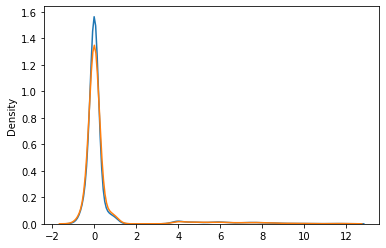

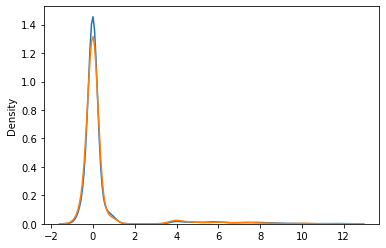

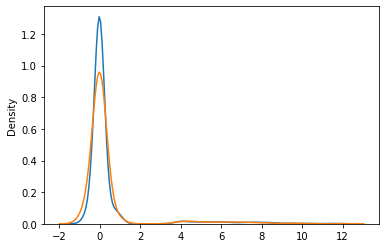

In [143]:
i = 10
sns.kdeplot(X_train.ravel())
sns.kdeplot(X_test.ravel())
plt.show()

idx = [True if i == 1 else False for i in y_train]
sns.kdeplot(X_train[:,:][idx].ravel())
idx = [True if i == 0 else False for i in y_train]
sns.kdeplot(X_train[:,:][idx].ravel())
plt.show()

idx = [True if i == 1 else False for i in y_test]
sns.kdeplot(X_test[:,:][idx].ravel())
idx = [True if i == 0 else False for i in y_test]
sns.kdeplot(X_test[:,:][idx].ravel())
plt.show()

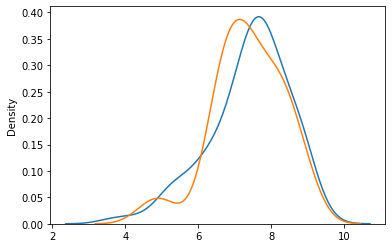

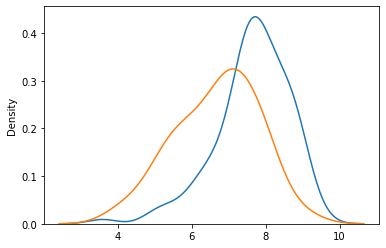

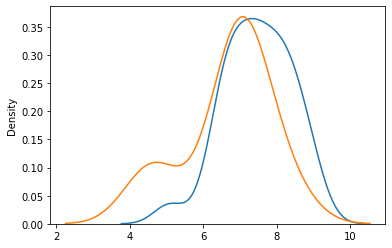

In [149]:
i = 5
sns.kdeplot(X_train[:,i])
sns.kdeplot(X_test[:,i])
plt.show()

idx = [True if i == 1 else False for i in y_train]
sns.kdeplot(X_train[:,i][idx])
idx = [True if i == 0 else False for i in y_train]
sns.kdeplot(X_train[:,i][idx])
plt.show()

idx = [True if i == 1 else False for i in y_test]
sns.kdeplot(X_test[:,i][idx])
idx = [True if i == 0 else False for i in y_test]
sns.kdeplot(X_test[:,i][idx])
plt.show()

# 构建Deep learning 模型

In [57]:
def evaluate(logits, real_labels):
    """
    logits: sigmoid
    real_labels (numpy.array, dim=1)
    
    Return
        acc, auc, f1_score_, sens, spec
    """
    # acc
    pred = [1 if i > 0.5 else 0 for i in logits]
    acc = np.sum(np.array(pred) == np.array(real_labels)) / len(real_labels)
    # matrix
    TN, FP, FN, TP = confusion_matrix(y_true=real_labels, y_pred=pred).ravel()
    # auc
    fpr, tpr, thresholds = metrics.roc_curve(real_labels, logits, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    # F1 score
    f1_score_ = f1_score(y_true=real_labels, y_pred=pred)
    # sens
    sens = TP/float(TP+FN)
    # spec
    spec = TN/float(TN+FP)
    return acc, auc, f1_score_, sens, spec

In [58]:
data = np.concatenate([dat_rna[:, candidates_rna[1]], dat_met[:, candidates_met[1]], dat_cnv[:, candidates_cnv[1]] ], 1)

data = np.nan_to_num(data)

data = data.astype('float32')

# data = torch.tensor([data, labels], dtype=torch.float32)
dataset = []
for i in range(len(labels)):
    dataset.append([torch.tensor(data[i]), torch.tensor(labels[i])])
    
data.shape, labels.shape

NameError: name 'dat_rna' is not defined

,years_to_birth,Tumor_purity,histological_type_glioblastomamultiforme(gbm),histological_type_treatedprimarygbm,histological_type_untreatedprimary(denovo)gbm,gender_female,gender_male,radiation_therapy_no,radiation_therapy_yes
attrib_name,,,,,,,,,
TCGA.02.0001,0.44,0.7876,0,0,1,1,0,0,1
TCGA.02.0003,0.50,0.9850,0,0,1,0,1,0,1
TCGA.02.0007,0.40,0.9850,0,1,0,1,0,0,1
TCGA.02.0009,0.61,0.9850,0,0,1,1,0,0,1
TCGA.02.0010,0.20,0.9850,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,0.67,0.8784,0,0,1,0,1,0,1
TCGA.41.2575,0.75,0.8956,0,0,1,0,1,0,1
TCGA.41.3392,0.88,0.8848,0,0,1,0,1,1,0


In [63]:
data = np.concatenate([df_omics[0].iloc[:, rna].sort_index().values, 
                       df_omics[1].iloc[:, cnv].sort_index().values, 
                       df_omics[2].iloc[:, met].sort_index().values, 
                       df_clin.sort_index().values,
                      ],
                      1)

data = np.nan_to_num(data)
data = data.astype('float32')

labels = df_label.sort_index().label.values

# data = torch.tensor([data, labels], dtype=torch.float32)
dataset = []
for i in range(len(labels)):
    dataset.append([torch.tensor(data[i]), torch.tensor(labels[i])])
    
data.shape, labels.shape

((220, 88), (220,))

In [62]:
df_omics[0].iloc[:, rna].sort_index()

,ADAM5P,ZNF614,SLC15A3,CIDEB,MSN,ZBTB38,tcag7.1314,SLC24A6,TPP1,SIL1,...,PRM2,STEAP3,ZNF771,RAB31,DYRK1B,LOC26010,CABP2,P4HB,F11R,CP
TCGA.02.0001,4.2197,4.6072,6.4073,5.7098,9.1485,7.6612,7.1249,5.7000,7.6620,6.9634,...,3.8775,6.2070,4.2146,11.0117,4.3168,6.3800,4.2058,9.4269,9.7303,5.5123
TCGA.02.0003,4.1182,4.2823,6.9385,5.6506,9.5051,8.9689,8.3652,5.1614,8.6845,6.7414,...,3.7189,5.9045,4.2724,8.9891,4.3352,6.8415,4.2785,9.9156,9.0787,6.8554
TCGA.02.0007,4.0738,4.3988,5.0967,5.0106,9.0511,8.2918,5.6115,5.8679,5.9713,7.5823,...,3.7087,7.0852,4.3974,8.2539,4.9238,6.2928,4.2721,11.0068,8.5278,10.1770
TCGA.02.0009,4.0119,4.1003,5.8273,5.6102,8.7493,8.6187,7.2129,5.7916,8.7346,6.7865,...,3.6525,6.3567,4.2623,9.4249,4.2783,7.0403,4.2054,9.8288,8.3124,4.1279
TCGA.02.0010,4.2165,4.2913,4.9155,5.0728,7.4383,5.3932,5.8786,5.3240,8.2135,6.8509,...,3.7564,4.9310,4.2729,5.8333,4.7801,6.2203,4.3310,9.0217,8.8047,10.1425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,3.8959,4.5443,6.5291,5.4149,10.1858,8.1808,7.5238,5.7329,8.2196,6.9597,...,3.7213,7.5337,4.1901,11.3157,4.0595,7.3002,4.1695,9.9252,5.5077,5.7918
TCGA.41.2575,4.0231,4.4331,4.5511,5.5499,9.1881,7.9177,8.1475,5.5268,8.1470,6.6913,...,3.5737,6.4000,4.2463,11.9522,4.0280,7.1502,3.8396,9.5883,5.3608,7.7478
TCGA.41.3392,3.9136,4.4612,6.0182,4.9280,10.3648,8.7011,8.6969,5.8691,9.3079,7.0430,...,3.5582,7.6505,4.2398,11.7921,4.0867,7.6344,4.0247,9.2881,6.3139,7.7238
TCGA.41.3393,3.7988,4.3651,5.5740,5.4766,10.1064,8.6333,7.8838,5.8631,8.7149,6.5800,...,3.4626,7.8837,4.1308,11.7807,4.1601,7.3178,3.7327,10.0733,6.1324,7.0741


In [64]:
class DeepMOI(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(DeepMOI, self).__init__()
        self.lin1 = nn.Linear(in_feat, 256)
        self.lin2 = nn.Linear(256, 64)
#         self.lin3 = nn.Linear(128, 64)
        self.lin4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
#         x = F.leaky_relu(x, 0.25)
        x = F.dropout(x, 0.5)
        
        x = self.lin2(x)
        x = torch.relu(x)
#         x = F.leaky_relu(x, 0.25)
        x = F.dropout(x, 0.5)
        
#         x = self.lin3(x)
#         x = torch.relu(x)
# #         x = F.leaky_relu(x, 0.25)
#         x = F.dropout(x, 0.5)
        
#         x = nn.Dropout(p=0.4)(x)
        x = self.lin4(x)
        logit = torch.sigmoid(x)
        
        return logit

In [84]:
dataset[0][0].shape[0]

88

In [65]:
indim= data.shape[1]
model = DeepMOI(indim, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.002)

dataset_train, dataset_test = train_test_split(dataset, test_size=0.3, random_state=seeds[-1]) 
loader = DataLoader(dataset_train, batch_size=32)

for epoch in range(500):
    model.train()
    loss_epoch = []
    for batch_ndx, sample in enumerate(loader):
        X = sample[0]
        Y = sample[1]
        logits = model(X)
        loss = nn.BCELoss()(logits, Y.reshape(-1,1).to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
        
    loss_epoch = np.mean(loss_epoch)
    
    y_train_proba, y_train = [], []
    for d in dataset_train:
        y_train_proba.append(model(d[0]).detach().numpy())
        y_train.append(d[1])
    acc, auc, f1_score_, sens, spec = evaluate(logits=y_train_proba, real_labels=y_train)
    print('Epoch {:2d} | Train_Loss {:.10f} | Train_ACC {:.3f} | Train_AUC {:.3f} | Train_F1_score {:.3f} | Train_Sens {:.3f} | Train_Spec {:.3f}'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )
   
    y_test_proba, y_test = [], []
    for d in dataset_test:
        y_test_proba.append(model(d[0]).detach().numpy())
        y_test.append(d[1])
    acc, auc, f1_score_, sens, spec = evaluate(logits=y_test_proba, real_labels=y_test)
    print('Epoch {:2d} | Test_Loss  {:.10f} | Test_ACC  {:.3f} | Test_AUC  {:.3f} | Test_F1_score  {:.3f} | Test_Sens  {:.3f} | Test_Spec  {:.3f}\n'.format(
                epoch, loss_epoch, acc, auc, f1_score_, sens, spec))

Epoch  0 | Train_Loss 0.8943936706 | Train_ACC 0.455 | Train_AUC 0.584 | Train_F1_score 0.488 | Train_Sens 0.351 | Train_Spec 0.750
Epoch  0 | Test_Loss  0.8943936706 | Test_ACC  0.303 | Test_AUC  0.389 | Test_F1_score  0.410 | Test_Sens  0.286 | Test_Spec  0.400

Epoch  1 | Train_Loss 0.8132513046 | Train_ACC 0.429 | Train_AUC 0.434 | Train_F1_score 0.532 | Train_Sens 0.439 | Train_Spec 0.400
Epoch  1 | Test_Loss  0.8132513046 | Test_ACC  0.621 | Test_AUC  0.604 | Test_F1_score  0.742 | Test_Sens  0.643 | Test_Spec  0.500

Epoch  2 | Train_Loss 0.6408474565 | Train_ACC 0.623 | Train_AUC 0.549 | Train_F1_score 0.746 | Train_Sens 0.746 | Train_Spec 0.275
Epoch  2 | Test_Loss  0.6408474565 | Test_ACC  0.606 | Test_AUC  0.586 | Test_F1_score  0.735 | Test_Sens  0.643 | Test_Spec  0.400

Epoch  3 | Train_Loss 0.6621949553 | Train_ACC 0.675 | Train_AUC 0.564 | Train_F1_score 0.792 | Train_Sens 0.833 | Train_Spec 0.225
Epoch  3 | Test_Loss  0.6621949553 | Test_ACC  0.682 | Test_AUC  0.514 | 

Epoch 31 | Train_Loss 0.5541517973 | Train_ACC 0.760 | Train_AUC 0.661 | Train_F1_score 0.860 | Train_Sens 1.000 | Train_Spec 0.075
Epoch 31 | Test_Loss  0.5541517973 | Test_ACC  0.833 | Test_AUC  0.664 | Test_F1_score  0.909 | Test_Sens  0.982 | Test_Spec  0.000

Epoch 32 | Train_Loss 0.5569421768 | Train_ACC 0.727 | Train_AUC 0.554 | Train_F1_score 0.842 | Train_Sens 0.982 | Train_Spec 0.000
Epoch 32 | Test_Loss  0.5569421768 | Test_ACC  0.864 | Test_AUC  0.552 | Test_F1_score  0.924 | Test_Sens  0.982 | Test_Spec  0.200

Epoch 33 | Train_Loss 0.5318711221 | Train_ACC 0.747 | Train_AUC 0.595 | Train_F1_score 0.852 | Train_Sens 0.982 | Train_Spec 0.075
Epoch 33 | Test_Loss  0.5318711221 | Test_ACC  0.848 | Test_AUC  0.648 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 34 | Train_Loss 0.5637298703 | Train_ACC 0.714 | Train_AUC 0.636 | Train_F1_score 0.829 | Train_Sens 0.939 | Train_Spec 0.075
Epoch 34 | Test_Loss  0.5637298703 | Test_ACC  0.864 | Test_AUC  0.586 | 

Epoch 63 | Test_Loss  0.5149950624 | Test_ACC  0.879 | Test_AUC  0.661 | Test_F1_score  0.933 | Test_Sens  1.000 | Test_Spec  0.200

Epoch 64 | Train_Loss 0.5137790561 | Train_ACC 0.727 | Train_AUC 0.804 | Train_F1_score 0.840 | Train_Sens 0.965 | Train_Spec 0.050
Epoch 64 | Test_Loss  0.5137790561 | Test_ACC  0.848 | Test_AUC  0.729 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 65 | Train_Loss 0.5073657870 | Train_ACC 0.747 | Train_AUC 0.693 | Train_F1_score 0.853 | Train_Sens 0.991 | Train_Spec 0.050
Epoch 65 | Test_Loss  0.5073657870 | Test_ACC  0.848 | Test_AUC  0.677 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 66 | Train_Loss 0.5023878455 | Train_ACC 0.721 | Train_AUC 0.741 | Train_F1_score 0.837 | Train_Sens 0.965 | Train_Spec 0.025
Epoch 66 | Test_Loss  0.5023878455 | Test_ACC  0.864 | Test_AUC  0.793 | Test_F1_score  0.926 | Test_Sens  1.000 | Test_Spec  0.100

Epoch 67 | Train_Loss 0.5163474441 | Train_ACC 0.747 | Train_AUC 0.671 |

Epoch 94 | Test_Loss  0.4769432008 | Test_ACC  0.818 | Test_AUC  0.607 | Test_F1_score  0.898 | Test_Sens  0.946 | Test_Spec  0.100

Epoch 95 | Train_Loss 0.4631476998 | Train_ACC 0.773 | Train_AUC 0.816 | Train_F1_score 0.864 | Train_Sens 0.974 | Train_Spec 0.200
Epoch 95 | Test_Loss  0.4631476998 | Test_ACC  0.818 | Test_AUC  0.577 | Test_F1_score  0.900 | Test_Sens  0.964 | Test_Spec  0.000

Epoch 96 | Train_Loss 0.4778182507 | Train_ACC 0.760 | Train_AUC 0.791 | Train_F1_score 0.855 | Train_Sens 0.956 | Train_Spec 0.200
Epoch 96 | Test_Loss  0.4778182507 | Test_ACC  0.848 | Test_AUC  0.673 | Test_F1_score  0.917 | Test_Sens  0.982 | Test_Spec  0.100

Epoch 97 | Train_Loss 0.4621679246 | Train_ACC 0.773 | Train_AUC 0.792 | Train_F1_score 0.864 | Train_Sens 0.974 | Train_Spec 0.200
Epoch 97 | Test_Loss  0.4621679246 | Test_ACC  0.848 | Test_AUC  0.564 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 98 | Train_Loss 0.4490421474 | Train_ACC 0.766 | Train_AUC 0.782 |

Epoch 125 | Test_Loss  0.4816392124 | Test_ACC  0.833 | Test_AUC  0.604 | Test_F1_score  0.908 | Test_Sens  0.964 | Test_Spec  0.100

Epoch 126 | Train_Loss 0.4576799452 | Train_ACC 0.773 | Train_AUC 0.826 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoch 126 | Test_Loss  0.4576799452 | Test_ACC  0.833 | Test_AUC  0.704 | Test_F1_score  0.909 | Test_Sens  0.982 | Test_Spec  0.000

Epoch 127 | Train_Loss 0.4285267472 | Train_ACC 0.792 | Train_AUC 0.779 | Train_F1_score 0.872 | Train_Sens 0.956 | Train_Spec 0.325
Epoch 127 | Test_Loss  0.4285267472 | Test_ACC  0.833 | Test_AUC  0.570 | Test_F1_score  0.906 | Test_Sens  0.946 | Test_Spec  0.200

Epoch 128 | Train_Loss 0.4796357691 | Train_ACC 0.773 | Train_AUC 0.786 | Train_F1_score 0.859 | Train_Sens 0.939 | Train_Spec 0.300
Epoch 128 | Test_Loss  0.4796357691 | Test_ACC  0.788 | Test_AUC  0.693 | Test_F1_score  0.879 | Test_Sens  0.911 | Test_Spec  0.100

Epoch 129 | Train_Loss 0.4549014628 | Train_ACC 0.747 | Train_AUC

Epoch 156 | Test_Loss  0.4419194162 | Test_ACC  0.848 | Test_AUC  0.707 | Test_F1_score  0.915 | Test_Sens  0.964 | Test_Spec  0.200

Epoch 157 | Train_Loss 0.4392951846 | Train_ACC 0.812 | Train_AUC 0.827 | Train_F1_score 0.882 | Train_Sens 0.947 | Train_Spec 0.425
Epoch 157 | Test_Loss  0.4392951846 | Test_ACC  0.879 | Test_AUC  0.721 | Test_F1_score  0.933 | Test_Sens  1.000 | Test_Spec  0.200

Epoch 158 | Train_Loss 0.4241695404 | Train_ACC 0.818 | Train_AUC 0.818 | Train_F1_score 0.886 | Train_Sens 0.956 | Train_Spec 0.425
Epoch 158 | Test_Loss  0.4241695404 | Test_ACC  0.879 | Test_AUC  0.752 | Test_F1_score  0.931 | Test_Sens  0.964 | Test_Spec  0.400

Epoch 159 | Train_Loss 0.4301165164 | Train_ACC 0.799 | Train_AUC 0.820 | Train_F1_score 0.874 | Train_Sens 0.947 | Train_Spec 0.375
Epoch 159 | Test_Loss  0.4301165164 | Test_ACC  0.848 | Test_AUC  0.737 | Test_F1_score  0.915 | Test_Sens  0.964 | Test_Spec  0.200

Epoch 160 | Train_Loss 0.3933656514 | Train_ACC 0.779 | Train_AUC

Epoch 189 | Test_Loss  0.4085277438 | Test_ACC  0.848 | Test_AUC  0.705 | Test_F1_score  0.914 | Test_Sens  0.946 | Test_Spec  0.300

Epoch 190 | Train_Loss 0.3784320533 | Train_ACC 0.805 | Train_AUC 0.825 | Train_F1_score 0.877 | Train_Sens 0.939 | Train_Spec 0.425
Epoch 190 | Test_Loss  0.3784320533 | Test_ACC  0.833 | Test_AUC  0.791 | Test_F1_score  0.903 | Test_Sens  0.911 | Test_Spec  0.400

Epoch 191 | Train_Loss 0.4048806429 | Train_ACC 0.818 | Train_AUC 0.879 | Train_F1_score 0.884 | Train_Sens 0.939 | Train_Spec 0.475
Epoch 191 | Test_Loss  0.4048806429 | Test_ACC  0.924 | Test_AUC  0.773 | Test_F1_score  0.957 | Test_Sens  1.000 | Test_Spec  0.500

Epoch 192 | Train_Loss 0.4046211243 | Train_ACC 0.805 | Train_AUC 0.862 | Train_F1_score 0.874 | Train_Sens 0.912 | Train_Spec 0.500
Epoch 192 | Test_Loss  0.4046211243 | Test_ACC  0.864 | Test_AUC  0.693 | Test_F1_score  0.920 | Test_Sens  0.929 | Test_Spec  0.500

Epoch 193 | Train_Loss 0.4257186890 | Train_ACC 0.786 | Train_AUC

Epoch 221 | Test_Loss  0.4079457104 | Test_ACC  0.833 | Test_AUC  0.714 | Test_F1_score  0.904 | Test_Sens  0.929 | Test_Spec  0.300

Epoch 222 | Train_Loss 0.4315557718 | Train_ACC 0.864 | Train_AUC 0.894 | Train_F1_score 0.913 | Train_Sens 0.965 | Train_Spec 0.575
Epoch 222 | Test_Loss  0.4315557718 | Test_ACC  0.833 | Test_AUC  0.712 | Test_F1_score  0.903 | Test_Sens  0.911 | Test_Spec  0.400

Epoch 223 | Train_Loss 0.4009429097 | Train_ACC 0.838 | Train_AUC 0.867 | Train_F1_score 0.897 | Train_Sens 0.956 | Train_Spec 0.500
Epoch 223 | Test_Loss  0.4009429097 | Test_ACC  0.833 | Test_AUC  0.814 | Test_F1_score  0.903 | Test_Sens  0.911 | Test_Spec  0.400

Epoch 224 | Train_Loss 0.4152600467 | Train_ACC 0.851 | Train_AUC 0.856 | Train_F1_score 0.905 | Train_Sens 0.956 | Train_Spec 0.550
Epoch 224 | Test_Loss  0.4152600467 | Test_ACC  0.833 | Test_AUC  0.802 | Test_F1_score  0.904 | Test_Sens  0.929 | Test_Spec  0.300

Epoch 225 | Train_Loss 0.4153054118 | Train_ACC 0.838 | Train_AUC

Epoch 252 | Test_Loss  0.4022671878 | Test_ACC  0.848 | Test_AUC  0.682 | Test_F1_score  0.912 | Test_Sens  0.929 | Test_Spec  0.400

Epoch 253 | Train_Loss 0.4408084273 | Train_ACC 0.838 | Train_AUC 0.868 | Train_F1_score 0.895 | Train_Sens 0.930 | Train_Spec 0.575
Epoch 253 | Test_Loss  0.4408084273 | Test_ACC  0.909 | Test_AUC  0.823 | Test_F1_score  0.947 | Test_Sens  0.964 | Test_Spec  0.600

Epoch 254 | Train_Loss 0.4152810991 | Train_ACC 0.838 | Train_AUC 0.875 | Train_F1_score 0.892 | Train_Sens 0.904 | Train_Spec 0.650
Epoch 254 | Test_Loss  0.4152810991 | Test_ACC  0.848 | Test_AUC  0.720 | Test_F1_score  0.912 | Test_Sens  0.929 | Test_Spec  0.400

Epoch 255 | Train_Loss 0.3673252940 | Train_ACC 0.831 | Train_AUC 0.858 | Train_F1_score 0.891 | Train_Sens 0.930 | Train_Spec 0.550
Epoch 255 | Test_Loss  0.3673252940 | Test_ACC  0.818 | Test_AUC  0.696 | Test_F1_score  0.891 | Test_Sens  0.875 | Test_Spec  0.500

Epoch 256 | Train_Loss 0.3698492765 | Train_ACC 0.818 | Train_AUC

Epoch 285 | Train_Loss 0.3922547519 | Train_ACC 0.831 | Train_AUC 0.885 | Train_F1_score 0.892 | Train_Sens 0.939 | Train_Spec 0.525
Epoch 285 | Test_Loss  0.3922547519 | Test_ACC  0.894 | Test_AUC  0.816 | Test_F1_score  0.939 | Test_Sens  0.964 | Test_Spec  0.500

Epoch 286 | Train_Loss 0.3806562841 | Train_ACC 0.851 | Train_AUC 0.861 | Train_F1_score 0.904 | Train_Sens 0.947 | Train_Spec 0.575
Epoch 286 | Test_Loss  0.3806562841 | Test_ACC  0.864 | Test_AUC  0.737 | Test_F1_score  0.922 | Test_Sens  0.946 | Test_Spec  0.400

Epoch 287 | Train_Loss 0.3694571316 | Train_ACC 0.838 | Train_AUC 0.860 | Train_F1_score 0.894 | Train_Sens 0.921 | Train_Spec 0.600
Epoch 287 | Test_Loss  0.3694571316 | Test_ACC  0.848 | Test_AUC  0.784 | Test_F1_score  0.912 | Test_Sens  0.929 | Test_Spec  0.400

Epoch 288 | Train_Loss 0.3724434912 | Train_ACC 0.877 | Train_AUC 0.849 | Train_F1_score 0.919 | Train_Sens 0.947 | Train_Spec 0.675
Epoch 288 | Test_Loss  0.3724434912 | Test_ACC  0.879 | Test_AUC  

Epoch 320 | Train_Loss 0.3439432085 | Train_ACC 0.864 | Train_AUC 0.853 | Train_F1_score 0.911 | Train_Sens 0.947 | Train_Spec 0.625
Epoch 320 | Test_Loss  0.3439432085 | Test_ACC  0.879 | Test_AUC  0.796 | Test_F1_score  0.930 | Test_Sens  0.946 | Test_Spec  0.500

Epoch 321 | Train_Loss 0.3708240986 | Train_ACC 0.857 | Train_AUC 0.881 | Train_F1_score 0.907 | Train_Sens 0.939 | Train_Spec 0.625
Epoch 321 | Test_Loss  0.3708240986 | Test_ACC  0.879 | Test_AUC  0.804 | Test_F1_score  0.930 | Test_Sens  0.946 | Test_Spec  0.500

Epoch 322 | Train_Loss 0.3695196271 | Train_ACC 0.838 | Train_AUC 0.877 | Train_F1_score 0.894 | Train_Sens 0.921 | Train_Spec 0.600
Epoch 322 | Test_Loss  0.3695196271 | Test_ACC  0.833 | Test_AUC  0.720 | Test_F1_score  0.903 | Test_Sens  0.911 | Test_Spec  0.400

Epoch 323 | Train_Loss 0.3566848814 | Train_ACC 0.857 | Train_AUC 0.871 | Train_F1_score 0.905 | Train_Sens 0.921 | Train_Spec 0.675
Epoch 323 | Test_Loss  0.3566848814 | Test_ACC  0.894 | Test_AUC  

Epoch 353 | Train_Loss 0.3851029158 | Train_ACC 0.851 | Train_AUC 0.897 | Train_F1_score 0.900 | Train_Sens 0.912 | Train_Spec 0.675
Epoch 353 | Test_Loss  0.3851029158 | Test_ACC  0.833 | Test_AUC  0.727 | Test_F1_score  0.903 | Test_Sens  0.911 | Test_Spec  0.400

Epoch 354 | Train_Loss 0.3539516985 | Train_ACC 0.825 | Train_AUC 0.896 | Train_F1_score 0.885 | Train_Sens 0.912 | Train_Spec 0.575
Epoch 354 | Test_Loss  0.3539516985 | Test_ACC  0.848 | Test_AUC  0.791 | Test_F1_score  0.911 | Test_Sens  0.911 | Test_Spec  0.500

Epoch 355 | Train_Loss 0.3647164702 | Train_ACC 0.870 | Train_AUC 0.895 | Train_F1_score 0.917 | Train_Sens 0.974 | Train_Spec 0.575
Epoch 355 | Test_Loss  0.3647164702 | Test_ACC  0.864 | Test_AUC  0.795 | Test_F1_score  0.920 | Test_Sens  0.929 | Test_Spec  0.500

Epoch 356 | Train_Loss 0.3549378872 | Train_ACC 0.864 | Train_AUC 0.881 | Train_F1_score 0.913 | Train_Sens 0.965 | Train_Spec 0.575
Epoch 356 | Test_Loss  0.3549378872 | Test_ACC  0.909 | Test_AUC  

Epoch 384 | Test_Loss  0.3338782430 | Test_ACC  0.864 | Test_AUC  0.846 | Test_F1_score  0.920 | Test_Sens  0.929 | Test_Spec  0.500

Epoch 385 | Train_Loss 0.3474119365 | Train_ACC 0.890 | Train_AUC 0.891 | Train_F1_score 0.928 | Train_Sens 0.956 | Train_Spec 0.700
Epoch 385 | Test_Loss  0.3474119365 | Test_ACC  0.848 | Test_AUC  0.727 | Test_F1_score  0.911 | Test_Sens  0.911 | Test_Spec  0.500

Epoch 386 | Train_Loss 0.3477038115 | Train_ACC 0.870 | Train_AUC 0.887 | Train_F1_score 0.915 | Train_Sens 0.939 | Train_Spec 0.675
Epoch 386 | Test_Loss  0.3477038115 | Test_ACC  0.833 | Test_AUC  0.768 | Test_F1_score  0.901 | Test_Sens  0.893 | Test_Spec  0.500

Epoch 387 | Train_Loss 0.3443785548 | Train_ACC 0.877 | Train_AUC 0.907 | Train_F1_score 0.918 | Train_Sens 0.939 | Train_Spec 0.700
Epoch 387 | Test_Loss  0.3443785548 | Test_ACC  0.848 | Test_AUC  0.762 | Test_F1_score  0.911 | Test_Sens  0.911 | Test_Spec  0.500

Epoch 388 | Train_Loss 0.3318240881 | Train_ACC 0.883 | Train_AUC

Epoch 418 | Train_Loss 0.3288334906 | Train_ACC 0.857 | Train_AUC 0.905 | Train_F1_score 0.908 | Train_Sens 0.947 | Train_Spec 0.600
Epoch 418 | Test_Loss  0.3288334906 | Test_ACC  0.848 | Test_AUC  0.773 | Test_F1_score  0.912 | Test_Sens  0.929 | Test_Spec  0.400

Epoch 419 | Train_Loss 0.3203625321 | Train_ACC 0.870 | Train_AUC 0.907 | Train_F1_score 0.915 | Train_Sens 0.947 | Train_Spec 0.650
Epoch 419 | Test_Loss  0.3203625321 | Test_ACC  0.848 | Test_AUC  0.746 | Test_F1_score  0.911 | Test_Sens  0.911 | Test_Spec  0.500

Epoch 420 | Train_Loss 0.3505130440 | Train_ACC 0.857 | Train_AUC 0.906 | Train_F1_score 0.907 | Train_Sens 0.939 | Train_Spec 0.625
Epoch 420 | Test_Loss  0.3505130440 | Test_ACC  0.833 | Test_AUC  0.812 | Test_F1_score  0.901 | Test_Sens  0.893 | Test_Spec  0.500

Epoch 421 | Train_Loss 0.2999316186 | Train_ACC 0.870 | Train_AUC 0.913 | Train_F1_score 0.915 | Train_Sens 0.947 | Train_Spec 0.650
Epoch 421 | Test_Loss  0.2999316186 | Test_ACC  0.864 | Test_AUC  

Epoch 451 | Train_Loss 0.3300269604 | Train_ACC 0.883 | Train_AUC 0.916 | Train_F1_score 0.922 | Train_Sens 0.939 | Train_Spec 0.725
Epoch 451 | Test_Loss  0.3300269604 | Test_ACC  0.848 | Test_AUC  0.732 | Test_F1_score  0.911 | Test_Sens  0.911 | Test_Spec  0.500

Epoch 452 | Train_Loss 0.3352218747 | Train_ACC 0.864 | Train_AUC 0.924 | Train_F1_score 0.911 | Train_Sens 0.947 | Train_Spec 0.625
Epoch 452 | Test_Loss  0.3352218747 | Test_ACC  0.833 | Test_AUC  0.777 | Test_F1_score  0.901 | Test_Sens  0.893 | Test_Spec  0.500

Epoch 453 | Train_Loss 0.3215358943 | Train_ACC 0.857 | Train_AUC 0.913 | Train_F1_score 0.906 | Train_Sens 0.930 | Train_Spec 0.650
Epoch 453 | Test_Loss  0.3215358943 | Test_ACC  0.864 | Test_AUC  0.798 | Test_F1_score  0.920 | Test_Sens  0.929 | Test_Spec  0.500

Epoch 454 | Train_Loss 0.3237207174 | Train_ACC 0.870 | Train_AUC 0.886 | Train_F1_score 0.916 | Train_Sens 0.956 | Train_Spec 0.625
Epoch 454 | Test_Loss  0.3237207174 | Test_ACC  0.833 | Test_AUC  

Epoch 483 | Train_Loss 0.3142988384 | Train_ACC 0.896 | Train_AUC 0.897 | Train_F1_score 0.932 | Train_Sens 0.956 | Train_Spec 0.725
Epoch 483 | Test_Loss  0.3142988384 | Test_ACC  0.833 | Test_AUC  0.695 | Test_F1_score  0.901 | Test_Sens  0.893 | Test_Spec  0.500

Epoch 484 | Train_Loss 0.3235679477 | Train_ACC 0.877 | Train_AUC 0.921 | Train_F1_score 0.921 | Train_Sens 0.965 | Train_Spec 0.625
Epoch 484 | Test_Loss  0.3235679477 | Test_ACC  0.864 | Test_AUC  0.729 | Test_F1_score  0.920 | Test_Sens  0.929 | Test_Spec  0.500

Epoch 485 | Train_Loss 0.3253993809 | Train_ACC 0.844 | Train_AUC 0.909 | Train_F1_score 0.898 | Train_Sens 0.930 | Train_Spec 0.600
Epoch 485 | Test_Loss  0.3253993809 | Test_ACC  0.879 | Test_AUC  0.791 | Test_F1_score  0.929 | Test_Sens  0.929 | Test_Spec  0.600

Epoch 486 | Train_Loss 0.3361070335 | Train_ACC 0.903 | Train_AUC 0.931 | Train_F1_score 0.936 | Train_Sens 0.956 | Train_Spec 0.750
Epoch 486 | Test_Loss  0.3361070335 | Test_ACC  0.818 | Test_AUC  

# GNN

In [50]:
def data_split(labels, test_size):
    """To split dataset into training dataset and testing dataset.
    Args:
        labels (numpy): The labels of samples.
        test_size (float, 0-1): The proportion of test data.
    
    Return:
        (list) index of training data, index of testing data
    """
    test_number = int(len(labels) * test_size)
    idx = list(range(len(labels)))
#     np.random.seed(102)
    np.random.shuffle(idx)
    return idx[test_number:], idx[:test_number]


In [51]:
def evaluate(logits, real_labels):
    """
    logits: sigmoid
    real_labels (numpy.array, dim=1)
    
    Return
        acc, auc, f1_score_, sens, spec
    """
    # acc
    pred = [1 if i > 0.5 else 0 for i in logits]
    acc = np.sum(np.array(pred) == np.array(real_labels)) / len(real_labels)
    acc = np.sum(np.array(pred) == np.array(real_labels.reshape(1,-1))[0]) / len(real_labels)

    # matrix
    TN, FP, FN, TP = confusion_matrix(y_true=real_labels, y_pred=pred).ravel()
    # auc
    fpr, tpr, thresholds = metrics.roc_curve(real_labels, logits, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    # F1 score
    f1_score_ = f1_score(y_true=real_labels, y_pred=pred)
    # sens / recall
    sens = TP/float(TP+FN)
    # spec
    spec = TN/float(TN+FP)
    return acc, auc, f1_score_, sens, spec

In [52]:
data = np.concatenate([
                       df_omics[0].iloc[:, rna].sort_index().values, 
                       df_omics[1].iloc[:, cnv].sort_index().values, 
                       df_omics[2].iloc[:, met].sort_index().values, 
                       df_clin.sort_index().values,
                      ],
                      1)

data = np.nan_to_num(data)
data = data.astype('float32')

labels = df_label.sort_index().label.values

# data = torch.tensor([data, labels], dtype=torch.float32)
dataset = []
for i in range(len(labels)):
    dataset.append([torch.tensor(data[i]), torch.tensor(labels[i])])
    
data.shape, labels.shape

((220, 88), (220,))

In [53]:
kg = KNNGraph(5)
sample_graph = kg(torch.tensor(data))

In [54]:
ll = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)
x = torch.tensor(data)

sample_graph.ndata['label'] = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)
sample_graph.ndata['x'] = torch.tensor(data)

sample_graph.ndata['x'].shape

torch.Size([220, 88])

In [55]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        
        self.conv1 = dglnn.GATConv(
            in_feats=in_feats, out_feats=256, num_heads=1)
        
        self.conv2 = dglnn.GATConv(
            in_feats=256, out_feats=128, num_heads=1)
        
        self.conv3 = dglnn.GATConv(
            in_feats=128, out_feats=64, num_heads=1)
        
        self.conv4 = dglnn.GATConv(
            in_feats=64, out_feats=1, num_heads=1)
        

    def forward(self, graph, h):
        with graph.local_scope():
            h = self.conv1(graph, h)
            h = h[:,0,:]
            h = torch.tanh(h)
            h = nn.Dropout(p=0.2)(h)
            
            h = self.conv2(graph, h)
            h = h[:,0,:]
            h = F.relu(h)
            h = nn.Dropout(p=0.4)(h)
            
            h = self.conv3(graph, h)
            h = h[:,0,:]
            h = F.relu(h)
            h = nn.Dropout(p=0.2)(h)
            
            
            h = self.conv4(graph, h)
            h = h[:,0,:]
            h = torch.sigmoid(h)
            
            return h

In [56]:
train_idx, test_idx = data_split(labels=sample_graph.ndata['label'], test_size=0.3)

indim= data.shape[1]

model = SAGE(indim, 256, 1)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

for epoch in range(300):
    model.train()
    # 使用所有节点(全图)进行前向传播计算
    logits = model(sample_graph, x)
    
    # 计算损失值
    loss = nn.BCELoss()(logits[train_idx], ll[train_idx] )
    
    # 进行反向传播计算
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    loss_epoch = loss.item()
    acc, auc, f1_score_, sens, spec = evaluate(logits=logits.detach().numpy()[train_idx], real_labels=sample_graph.ndata['label'][train_idx])
    print('Epoch {:2d} | Train_Loss {:.3f} | Train_ACC {:.3f} | Train_AUC {:.3f} | Train_F1_score {:.3f} | Train_Sens {:.3f} | Train_Spec {:.3f}'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )

    acc, auc, f1_score_, sens, spec = evaluate(logits=logits.detach().numpy()[test_idx], real_labels=sample_graph.ndata['label'][test_idx])
    print('Epoch {:2d} | Test_Loss {:.3f} | Test_ACC {:.3f} | Test_AUC {:.3f} | Test_F1_score {:.3f} | Test_Sens {:.3f} | Test_Spec {:.3f}\n'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )

Epoch  0 | Train_Loss 1.034 | Train_ACC 0.779 | Train_AUC 0.657 | Train_F1_score 0.876 | Train_Sens 1.000 | Train_Spec 0.000
Epoch  0 | Test_Loss 1.034 | Test_ACC 0.758 | Test_AUC 0.564 | Test_F1_score 0.862 | Test_Sens 1.000 | Test_Spec 0.000

Epoch  1 | Train_Loss 0.705 | Train_ACC 0.630 | Train_AUC 0.422 | Train_F1_score 0.767 | Train_Sens 0.783 | Train_Spec 0.088
Epoch  1 | Test_Loss 0.705 | Test_ACC 0.697 | Test_AUC 0.426 | Test_F1_score 0.811 | Test_Sens 0.860 | Test_Spec 0.188

Epoch  2 | Train_Loss 0.762 | Train_ACC 0.539 | Train_AUC 0.543 | Train_F1_score 0.647 | Train_Sens 0.542 | Train_Spec 0.529
Epoch  2 | Test_Loss 0.762 | Test_ACC 0.500 | Test_AUC 0.532 | Test_F1_score 0.602 | Test_Sens 0.500 | Test_Spec 0.500

Epoch  3 | Train_Loss 0.564 | Train_ACC 0.753 | Train_AUC 0.548 | Train_F1_score 0.854 | Train_Sens 0.925 | Train_Spec 0.147
Epoch  3 | Test_Loss 0.564 | Test_ACC 0.742 | Test_AUC 0.440 | Test_F1_score 0.847 | Test_Sens 0.940 | Test_Spec 0.125

Epoch  4 | Train_Los

Epoch 36 | Train_Loss 0.437 | Train_ACC 0.831 | Train_AUC 0.802 | Train_F1_score 0.894 | Train_Sens 0.917 | Train_Spec 0.529
Epoch 36 | Test_Loss 0.437 | Test_ACC 0.727 | Test_AUC 0.662 | Test_F1_score 0.830 | Test_Sens 0.880 | Test_Spec 0.250

Epoch 37 | Train_Loss 0.419 | Train_ACC 0.844 | Train_AUC 0.796 | Train_F1_score 0.907 | Train_Sens 0.975 | Train_Spec 0.382
Epoch 37 | Test_Loss 0.419 | Test_ACC 0.773 | Test_AUC 0.691 | Test_F1_score 0.865 | Test_Sens 0.960 | Test_Spec 0.188

Epoch 38 | Train_Loss 0.448 | Train_ACC 0.799 | Train_AUC 0.825 | Train_F1_score 0.883 | Train_Sens 0.975 | Train_Spec 0.176
Epoch 38 | Test_Loss 0.448 | Test_ACC 0.742 | Test_AUC 0.689 | Test_F1_score 0.850 | Test_Sens 0.960 | Test_Spec 0.062

Epoch 39 | Train_Loss 0.410 | Train_ACC 0.831 | Train_AUC 0.809 | Train_F1_score 0.893 | Train_Sens 0.908 | Train_Spec 0.559
Epoch 39 | Test_Loss 0.410 | Test_ACC 0.758 | Test_AUC 0.730 | Test_F1_score 0.846 | Test_Sens 0.880 | Test_Spec 0.375

Epoch 40 | Train_Los

Epoch 74 | Train_Loss 0.405 | Train_ACC 0.838 | Train_AUC 0.809 | Train_F1_score 0.898 | Train_Sens 0.917 | Train_Spec 0.559
Epoch 74 | Test_Loss 0.405 | Test_ACC 0.742 | Test_AUC 0.701 | Test_F1_score 0.838 | Test_Sens 0.880 | Test_Spec 0.312

Epoch 75 | Train_Loss 0.386 | Train_ACC 0.844 | Train_AUC 0.833 | Train_F1_score 0.907 | Train_Sens 0.975 | Train_Spec 0.382
Epoch 75 | Test_Loss 0.386 | Test_ACC 0.758 | Test_AUC 0.695 | Test_F1_score 0.855 | Test_Sens 0.940 | Test_Spec 0.188

Epoch 76 | Train_Loss 0.399 | Train_ACC 0.831 | Train_AUC 0.797 | Train_F1_score 0.898 | Train_Sens 0.950 | Train_Spec 0.412
Epoch 76 | Test_Loss 0.399 | Test_ACC 0.758 | Test_AUC 0.754 | Test_F1_score 0.855 | Test_Sens 0.940 | Test_Spec 0.188

Epoch 77 | Train_Loss 0.375 | Train_ACC 0.831 | Train_AUC 0.840 | Train_F1_score 0.895 | Train_Sens 0.925 | Train_Spec 0.500
Epoch 77 | Test_Loss 0.375 | Test_ACC 0.758 | Test_AUC 0.706 | Test_F1_score 0.852 | Test_Sens 0.920 | Test_Spec 0.250

Epoch 78 | Train_Los

Epoch 112 | Train_Loss 0.413 | Train_ACC 0.831 | Train_AUC 0.841 | Train_F1_score 0.902 | Train_Sens 1.000 | Train_Spec 0.235
Epoch 112 | Test_Loss 0.413 | Test_ACC 0.758 | Test_AUC 0.704 | Test_F1_score 0.860 | Test_Sens 0.980 | Test_Spec 0.062

Epoch 113 | Train_Loss 0.409 | Train_ACC 0.851 | Train_AUC 0.812 | Train_F1_score 0.912 | Train_Sens 0.992 | Train_Spec 0.353
Epoch 113 | Test_Loss 0.409 | Test_ACC 0.758 | Test_AUC 0.720 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 114 | Train_Loss 0.387 | Train_ACC 0.851 | Train_AUC 0.839 | Train_F1_score 0.911 | Train_Sens 0.983 | Train_Spec 0.382
Epoch 114 | Test_Loss 0.387 | Test_ACC 0.788 | Test_AUC 0.704 | Test_F1_score 0.873 | Test_Sens 0.960 | Test_Spec 0.250

Epoch 115 | Train_Loss 0.375 | Train_ACC 0.870 | Train_AUC 0.830 | Train_F1_score 0.922 | Train_Sens 0.983 | Train_Spec 0.471
Epoch 115 | Test_Loss 0.375 | Test_ACC 0.803 | Test_AUC 0.696 | Test_F1_score 0.883 | Test_Sens 0.980 | Test_Spec 0.250

Epoch 116 | 

Epoch 149 | Train_Loss 0.379 | Train_ACC 0.864 | Train_AUC 0.828 | Train_F1_score 0.917 | Train_Sens 0.967 | Train_Spec 0.500
Epoch 149 | Test_Loss 0.379 | Test_ACC 0.803 | Test_AUC 0.754 | Test_F1_score 0.881 | Test_Sens 0.960 | Test_Spec 0.312

Epoch 150 | Train_Loss 0.407 | Train_ACC 0.818 | Train_AUC 0.825 | Train_F1_score 0.887 | Train_Sens 0.917 | Train_Spec 0.471
Epoch 150 | Test_Loss 0.407 | Test_ACC 0.758 | Test_AUC 0.718 | Test_F1_score 0.852 | Test_Sens 0.920 | Test_Spec 0.250

Epoch 151 | Train_Loss 0.395 | Train_ACC 0.844 | Train_AUC 0.818 | Train_F1_score 0.905 | Train_Sens 0.950 | Train_Spec 0.471
Epoch 151 | Test_Loss 0.395 | Test_ACC 0.758 | Test_AUC 0.735 | Test_F1_score 0.852 | Test_Sens 0.920 | Test_Spec 0.250

Epoch 152 | Train_Loss 0.394 | Train_ACC 0.831 | Train_AUC 0.830 | Train_F1_score 0.893 | Train_Sens 0.908 | Train_Spec 0.559
Epoch 152 | Test_Loss 0.394 | Test_ACC 0.758 | Test_AUC 0.755 | Test_F1_score 0.849 | Test_Sens 0.900 | Test_Spec 0.312

Epoch 153 | 

Epoch 195 | Train_Loss 0.378 | Train_ACC 0.844 | Train_AUC 0.844 | Train_F1_score 0.908 | Train_Sens 0.992 | Train_Spec 0.324
Epoch 195 | Test_Loss 0.378 | Test_ACC 0.773 | Test_AUC 0.731 | Test_F1_score 0.865 | Test_Sens 0.960 | Test_Spec 0.188

Epoch 196 | Train_Loss 0.394 | Train_ACC 0.831 | Train_AUC 0.822 | Train_F1_score 0.900 | Train_Sens 0.975 | Train_Spec 0.324
Epoch 196 | Test_Loss 0.394 | Test_ACC 0.758 | Test_AUC 0.671 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 197 | Train_Loss 0.379 | Train_ACC 0.844 | Train_AUC 0.831 | Train_F1_score 0.905 | Train_Sens 0.950 | Train_Spec 0.471
Epoch 197 | Test_Loss 0.379 | Test_ACC 0.758 | Test_AUC 0.711 | Test_F1_score 0.855 | Test_Sens 0.940 | Test_Spec 0.188

Epoch 198 | Train_Loss 0.392 | Train_ACC 0.831 | Train_AUC 0.831 | Train_F1_score 0.893 | Train_Sens 0.908 | Train_Spec 0.559
Epoch 198 | Test_Loss 0.392 | Test_ACC 0.773 | Test_AUC 0.679 | Test_F1_score 0.857 | Test_Sens 0.900 | Test_Spec 0.375

Epoch 199 | 

Epoch 242 | Train_Loss 0.352 | Train_ACC 0.851 | Train_AUC 0.858 | Train_F1_score 0.908 | Train_Sens 0.942 | Train_Spec 0.529
Epoch 242 | Test_Loss 0.352 | Test_ACC 0.758 | Test_AUC 0.768 | Test_F1_score 0.849 | Test_Sens 0.900 | Test_Spec 0.312

Epoch 243 | Train_Loss 0.372 | Train_ACC 0.851 | Train_AUC 0.845 | Train_F1_score 0.911 | Train_Sens 0.975 | Train_Spec 0.412
Epoch 243 | Test_Loss 0.372 | Test_ACC 0.773 | Test_AUC 0.700 | Test_F1_score 0.862 | Test_Sens 0.940 | Test_Spec 0.250

Epoch 244 | Train_Loss 0.411 | Train_ACC 0.838 | Train_AUC 0.827 | Train_F1_score 0.903 | Train_Sens 0.975 | Train_Spec 0.353
Epoch 244 | Test_Loss 0.411 | Test_ACC 0.773 | Test_AUC 0.729 | Test_F1_score 0.865 | Test_Sens 0.960 | Test_Spec 0.188

Epoch 245 | Train_Loss 0.408 | Train_ACC 0.831 | Train_AUC 0.829 | Train_F1_score 0.902 | Train_Sens 1.000 | Train_Spec 0.235
Epoch 245 | Test_Loss 0.408 | Test_ACC 0.758 | Test_AUC 0.667 | Test_F1_score 0.860 | Test_Sens 0.980 | Test_Spec 0.062

Epoch 246 | 

Epoch 280 | Train_Loss 0.384 | Train_ACC 0.844 | Train_AUC 0.829 | Train_F1_score 0.902 | Train_Sens 0.925 | Train_Spec 0.559
Epoch 280 | Test_Loss 0.384 | Test_ACC 0.758 | Test_AUC 0.711 | Test_F1_score 0.849 | Test_Sens 0.900 | Test_Spec 0.312

Epoch 281 | Train_Loss 0.378 | Train_ACC 0.838 | Train_AUC 0.835 | Train_F1_score 0.903 | Train_Sens 0.975 | Train_Spec 0.353
Epoch 281 | Test_Loss 0.378 | Test_ACC 0.758 | Test_AUC 0.718 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 282 | Train_Loss 0.381 | Train_ACC 0.851 | Train_AUC 0.814 | Train_F1_score 0.913 | Train_Sens 1.000 | Train_Spec 0.324
Epoch 282 | Test_Loss 0.381 | Test_ACC 0.758 | Test_AUC 0.691 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 283 | Train_Loss 0.378 | Train_ACC 0.864 | Train_AUC 0.845 | Train_F1_score 0.919 | Train_Sens 0.992 | Train_Spec 0.412
Epoch 283 | Test_Loss 0.378 | Test_ACC 0.803 | Test_AUC 0.738 | Test_F1_score 0.883 | Test_Sens 0.980 | Test_Spec 0.250

Epoch 284 | 